In [83]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pickle as pkl

In [96]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

cuda=True
batch_size = 64

DEVICE = torch.device("cuda" if cuda else "cpu")
dataset_path = '~/datasets'

mnist_transform = transforms.Compose([
        transforms.ToTensor()
])

kwargs = {'num_workers': 0, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)


train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [97]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        hidden_dim = 128
    
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, output_size)
        
        # dropout layer - Dropout is only used for Discriminator in this case
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2) 
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        out = torch.sigmoid(self.fc3(x))
        
        return out


In [98]:
class Generator(nn.Module):

    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        hidden_dim = 256
    
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)


    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2) 
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        out = torch.tanh(self.fc4(x))

        return out

In [101]:
from torch.autograd import Variable
dtype = torch.cuda.FloatTensor

def real_loss(predicted_outputs, loss_fn, device, smooth=True):
    batch_size = predicted_outputs.size(0)
    predicted_outputs = predicted_outputs.type(torch.FloatTensor).to(device)
    # label smoothing
    if smooth:
        #Label smoothing: Generating values between 0.8 and 1
        labels = torch.randint(80, 100, (batch_size,), dtype=torch.float)
        labels = labels / 100
        labels = torch.round(labels, decimals=2)
        labels = labels.to(device)
    else:
        labels = torch.ones(batch_size).to(device) 
    
    # calculate loss
    loss = loss_fn(predicted_outputs.squeeze(), labels)
    return loss


def fake_loss(predicted_outputs, loss_fn, device, smooth=True):
    batch_size = predicted_outputs.size(0)
    predicted_outputs = predicted_outputs.type(torch.FloatTensor).to(device)
    if smooth:
        #Label smoothing: Generating values between 0 and 0.1
        labels = torch.randint(1, 20, (batch_size,), dtype=torch.float)
        labels = labels / 100
        labels = torch.round(labels, decimals=2)
        labels = labels.to(device)
    else:
        labels = torch.zeros(batch_size)
        labels = labels.to(device)
    # calculate loss
    loss = loss_fn(predicted_outputs.squeeze(), labels)
    return loss

In [102]:
# Instantiate Discriminator and Generator
d = Discriminator(input_size=784, output_size=1)
g = Generator(input_size=100, output_size=784)
print(d)
print()
print(g)

# Optimizers
d_optim = optim.Adam(d.parameters(), lr=0.0002)
g_optim = optim.Adam(g.parameters(), lr=0.0002)

device = 'cuda' if torch.cuda.is_available() else 'cpu'



Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)


In [103]:
import pickle as pkl

# Train for 100 epochs
num_epochs = 100
z_size = 100

samples = []
losses = []

loss_fn = nn.BCELoss() #Note - BCELoss should be used instead of BCELogitsLoss because of sigmoid activation function used in Discriminator

print_every = 800

# Just for sampling, get 100 images
sample_size=100
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float().to(device)

#Converting to cuda
d = d.to(device)
g = g.to(device)

# Training
d.train()
g.train()

#Start original training
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):

        real_images = real_images.to(device)
                
        batch_size = real_images.size(0)
        
        ## Rescaling image here is easier instead of rescaling in dataloader (Scaled to [-1,1])
        real_images = real_images*2 - 1 
        
        #Discriminator training
        d_optim.zero_grad()
        
        #Train with real images. Compute loss on real images and smooth the labels
        D_real = d(real_images)
        d_real_loss = real_loss(D_real, loss_fn, device, smooth=True)
        
        #Train with fake images. Generate random fake images (noises)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = g(z)
        
        # Identify the fake loss       
        D_fake = d(fake_images)
        d_fake_loss = fake_loss(D_fake, loss_fn, device, smooth=True)
        
        # Calculate total loss and perform backpropagation
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optim.step()
        
        
        #Finally, train the generator
        g_optim.zero_grad()

        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float().to(device)
        fake_images = g(z)
        
        # Compute the discriminator losses on fake images 
        #NOTE - Using REAL LOSS here
        D_fake = d(fake_images)
        g_loss = real_loss(D_fake, loss_fn, device, smooth=True)
        
        # perform final backpropagation
        g_loss.backward()
        g_optim.step()

        #Print Frequency
        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    #Save the respective losses
    losses.append((d_loss.item(), g_loss.item()))
    
    # Generate, save samples for fake images. See how well generator is doing
    g.eval() 
    samples_z = g(fixed_z)
    samples.append(samples_z)

    #Finally, back to train mode after eval mode
    g.train() 

Epoch [    1/  100] | d_loss: 1.3919 | g_loss: 0.6743
Epoch [    1/  100] | d_loss: 0.8910 | g_loss: 1.8273
Epoch [    2/  100] | d_loss: 1.4295 | g_loss: 1.5640
Epoch [    2/  100] | d_loss: 1.1570 | g_loss: 1.0658
Epoch [    3/  100] | d_loss: 0.9135 | g_loss: 1.4831
Epoch [    3/  100] | d_loss: 1.0443 | g_loss: 1.5160
Epoch [    4/  100] | d_loss: 0.8565 | g_loss: 1.5997
Epoch [    4/  100] | d_loss: 0.8860 | g_loss: 1.6103
Epoch [    5/  100] | d_loss: 1.0239 | g_loss: 1.4359
Epoch [    5/  100] | d_loss: 1.1216 | g_loss: 1.7022
Epoch [    6/  100] | d_loss: 0.9904 | g_loss: 1.7417
Epoch [    6/  100] | d_loss: 1.1882 | g_loss: 1.1073
Epoch [    7/  100] | d_loss: 1.0947 | g_loss: 1.1096
Epoch [    7/  100] | d_loss: 1.0579 | g_loss: 1.3716
Epoch [    8/  100] | d_loss: 1.2031 | g_loss: 0.9703
Epoch [    8/  100] | d_loss: 1.0539 | g_loss: 1.2201
Epoch [    9/  100] | d_loss: 1.0197 | g_loss: 1.2361
Epoch [    9/  100] | d_loss: 0.9805 | g_loss: 1.2068
Epoch [   10/  100] | d_loss

In [104]:
# Save training generator samples
with open('samples_to_save.pkl', 'wb') as f:
    pkl.dump(samples, f)

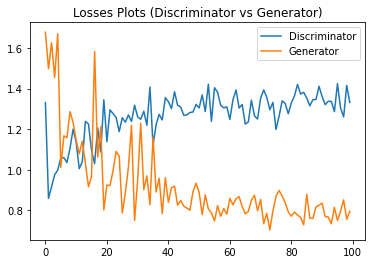

In [105]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Losses Plots (Discriminator vs Generator)")
plt.legend()

In [106]:
# Function to view samples
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(12,12), nrows=10, ncols=10, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

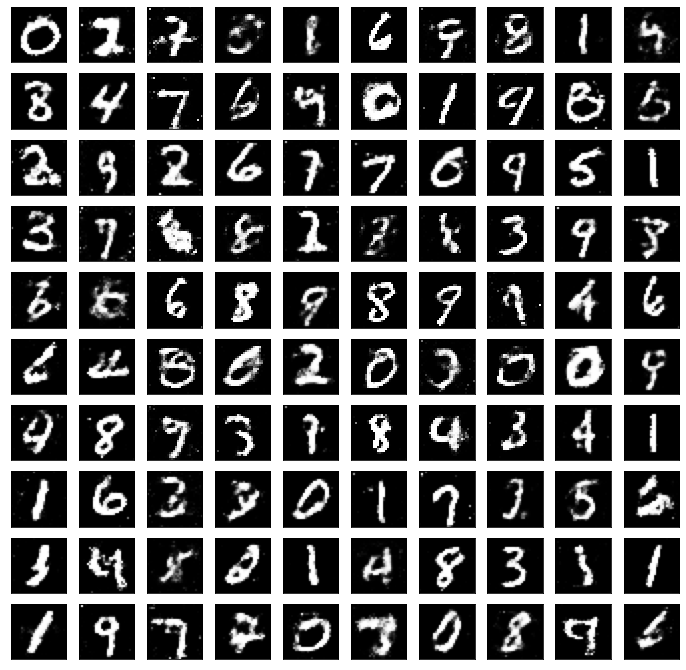

In [112]:
#Generate random 100 noise fake images, pass through generator and plot
sample_size=100
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float().to(device)

g.eval() 
g = g.to(device)
rand_images = g(rand_z)
numpy_format = rand_images.detach().cpu().numpy()

#Plot the images - Last epoch
view_samples(-1, [numpy_format])